In [55]:
# Goal: predict survival outcomes of Titanic passengers using a 
# variety of approaches.
rm(list=ls())
library(titanic)          # titanic data set
library(randomForest)     # bagging and randomForest
library(gbm)              # boosting
library(na.tools)
options(digits=3)

In [56]:
# Look at data:
head(titanic_train)
# Tabulate:
summary(titanic_train)
# Survived will be response variable.
# I will drop PassengerId, Name, Ticket, and Cabin, as not easily 
# tractible in this analysis.
titanic_train_v1 <- subset(titanic_train, select=-c(PassengerId,Name,Ticket,Cabin))
head(titanic_train_v1)
summary(titanic_train_v1)
# Perfect.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.28,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.92,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.10,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.46,,Q


  PassengerId     Survived         Pclass         Name          
 Min.   :  1   Min.   :0.000   Min.   :1.00   Length:891        
 1st Qu.:224   1st Qu.:0.000   1st Qu.:2.00   Class :character  
 Median :446   Median :0.000   Median :3.00   Mode  :character  
 Mean   :446   Mean   :0.384   Mean   :2.31                     
 3rd Qu.:668   3rd Qu.:1.000   3rd Qu.:3.00                     
 Max.   :891   Max.   :1.000   Max.   :3.00                     
                                                                
     Sex                 Age           SibSp          Parch     
 Length:891         Min.   : 0.4   Min.   :0.00   Min.   :0.00  
 Class :character   1st Qu.:20.1   1st Qu.:0.00   1st Qu.:0.00  
 Mode  :character   Median :28.0   Median :0.00   Median :0.00  
                    Mean   :29.7   Mean   :0.52   Mean   :0.38  
                    3rd Qu.:38.0   3rd Qu.:1.00   3rd Qu.:0.00  
                    Max.   :80.0   Max.   :8.00   Max.   :6.00  
                    NA's 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>
1,0,3,male,22,1,0,7.25,S
2,1,1,female,38,1,0,71.28,C
3,1,3,female,26,0,0,7.92,S
4,1,1,female,35,1,0,53.10,S
5,0,3,male,35,0,0,8.05,S
6,0,3,male,NA,0,0,8.46,Q


    Survived         Pclass         Sex                 Age      
 Min.   :0.000   Min.   :1.00   Length:891         Min.   : 0.4  
 1st Qu.:0.000   1st Qu.:2.00   Class :character   1st Qu.:20.1  
 Median :0.000   Median :3.00   Mode  :character   Median :28.0  
 Mean   :0.384   Mean   :2.31                      Mean   :29.7  
 3rd Qu.:1.000   3rd Qu.:3.00                      3rd Qu.:38.0  
 Max.   :1.000   Max.   :3.00                      Max.   :80.0  
                                                   NA's   :177   
     SibSp          Parch           Fare       Embarked        
 Min.   :0.00   Min.   :0.00   Min.   :  0   Length:891        
 1st Qu.:0.00   1st Qu.:0.00   1st Qu.:  8   Class :character  
 Median :0.00   Median :0.00   Median : 14   Mode  :character  
 Mean   :0.52   Mean   :0.38   Mean   : 32                     
 3rd Qu.:1.00   3rd Qu.:0.00   3rd Qu.: 31                     
 Max.   :8.00   Max.   :6.00   Max.   :512                     
                        

In [57]:
table(titanic_train_v1$Survived, useNA="always")
# Format this as a factor:
titanic_train_v1$Survived <- as.factor(titanic_train_v1$Survived)
# Perfect; all values of 1 or 0.
table(titanic_train_v1$Pclass, useNA="always")
titanic_train_v1$Pclass <- as.factor(titanic_train_v1$Pclass)
# Perfect; all vals of 1, 2, or 3rd class.
table(titanic_train_v1$Sex, useNA="always")
titanic_train_v1$Sex <- as.factor(titanic_train_v1$Sex)
# Perfect; all vals of Male or Female.
table(titanic_train_v1$Age, useNA="always")
# All vals between 0 and 80.  177 vals of NA; I'll map those to mean val:
# Helper value:
mean_age <- round(mean(na.rm(titanic_train_v1$Age)), 2)
titanic_train_v1$Age <- ifelse(is.na(titanic_train_v1$Age), mean_age, 
                                titanic_train_v1$Age)
table(titanic_train_v1$Age, useNA="always")
# Perfect!
table(titanic_train_v1$SibSp, useNA="always")
titanic_train_v1$SibSp <- as.factor(titanic_train_v1$SibSp)
# Perfect; vals of 0-8 with no NA
table(titanic_train_v1$Parch, useNA="always")
titanic_train_v1$Parch <- as.factor(titanic_train_v1$Parch)
# Perfect; vals of 0-6 with no NA
table(titanic_train_v1$Fare, useNA="always")
# Vals between 0 and 512, no NA.  At this stage, I will not 
# correct any vals of 0 or possible outlier of 512.
table(titanic_train_v1$Embarked, useNA="always")
# Vals of C, Q, and S; no NA.  There may be 2 blanks.
# titanic_train_v1[titanic_train_v1$Embarked=='',]  # There are 2 blanks.
# Change 2 blanks to UK=unknown:
titanic_train_v1$Embarked <- ifelse(titanic_train_v1$Embarked=='', 'UK', 
                                    titanic_train_v1$Embarked )
table(titanic_train_v1$Embarked, useNA="always")
titanic_train_v1$Embarked <- as.factor(titanic_train_v1$Embarked)
# Perfect.


   0    1 <NA> 
 549  342    0 


   1    2    3 <NA> 
 216  184  491    0 


female   male   <NA> 
   314    577      0 


0.42 0.67 0.75 0.83 0.92    1    2    3    4    5    6    7    8    9   10   11 
   1    1    2    2    1    7   10    6   10    4    3    3    4    8    2    4 
  12   13   14 14.5   15   16   17   18   19   20 20.5   21   22   23 23.5   24 
   1    2    6    1    5   17   13   26   25   15    1   24   27   15    1   30 
24.5   25   26   27   28 28.5   29   30 30.5   31   32 32.5   33   34 34.5   35 
   1   23   18   18   25    2   20   25    2   17   18    2   15   15    1   18 
  36 36.5   37   38   39   40 40.5   41   42   43   44   45 45.5   46   47   48 
  22    1    6   11   14   13    2    6   13    5    9   12    2    3    9    9 
  49   50   51   52   53   54   55 55.5   56   57   58   59   60   61   62   63 
   6   10    7    6    1    8    2    1    4    2    5    2    4    3    4    2 
  64   65   66   70 70.5   71   74   80 <NA> 
   2    3    1    2    1    2    1    1  177 


0.42 0.67 0.75 0.83 0.92    1    2    3    4    5    6    7    8    9   10   11 
   1    1    2    2    1    7   10    6   10    4    3    3    4    8    2    4 
  12   13   14 14.5   15   16   17   18   19   20 20.5   21   22   23 23.5   24 
   1    2    6    1    5   17   13   26   25   15    1   24   27   15    1   30 
24.5   25   26   27   28 28.5   29 29.7   30 30.5   31   32 32.5   33   34 34.5 
   1   23   18   18   25    2   20  177   25    2   17   18    2   15   15    1 
  35   36 36.5   37   38   39   40 40.5   41   42   43   44   45 45.5   46   47 
  18   22    1    6   11   14   13    2    6   13    5    9   12    2    3    9 
  48   49   50   51   52   53   54   55 55.5   56   57   58   59   60   61   62 
   9    6   10    7    6    1    8    2    1    4    2    5    2    4    3    4 
  63   64   65   66   70 70.5   71   74   80 <NA> 
   2    2    3    1    2    1    2    1    1    0 


   0    1    2    3    4    5    8 <NA> 
 608  209   28   16   18    5    7    0 


   0    1    2    3    4    5    6 <NA> 
 678  118   80    5    4    5    1    0 


       0   4.0125        5   6.2375   6.4375     6.45   6.4958     6.75 
      15        1        1        1        1        1        2        2 
  6.8583     6.95    6.975   7.0458     7.05   7.0542    7.125   7.1417 
       1        1        2        1        7        2        4        1 
   7.225   7.2292     7.25   7.3125   7.4958   7.5208     7.55   7.6292 
      12       15       13        1        3        1        4        1 
    7.65    7.725   7.7292   7.7333   7.7375   7.7417     7.75    7.775 
       4        1        1        4        2        1       34       16 
  7.7875   7.7958      7.8   7.8292   7.8542    7.875   7.8792   7.8875 
       1        6        1        2       13        1        4        1 
  7.8958    7.925   8.0292     8.05   8.1125   8.1375   8.1583      8.3 
      38       18        1       43        1        1        1        1 
  8.3625   8.4042   8.4333   8.4583   8.5167   8.6542   8.6625   8.6833 
       1        1        1        1        1      


        C    Q    S <NA> 
   2  168   77  644    0 


   C    Q    S   UK <NA> 
 168   77  644    2    0 

In [58]:
# Ensure that all categorical vars are factors and numerical vars are dbl:
head(titanic_train_v1)
# Yay!

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
1,0,3,male,22.0,1,0,7.25,S
2,1,1,female,38.0,1,0,71.28,C
3,1,3,female,26.0,0,0,7.92,S
4,1,1,female,35.0,1,0,53.10,S
5,0,3,male,35.0,0,0,8.05,S
6,0,3,male,29.7,0,0,8.46,Q


In [69]:
# As titanic_test set does not have values of response vars, here for simplicity
# I split the titanic_train set into 2 sets: real_train and real_test:
num_row    <- nrow(titanic_train_v1)
# print(num_row)
train_size <- round(0.7*num_row, 0)
# print(train_size)
set.seed(1)
train_ind  <- sample(1:num_row, train_size, replace=FALSE)
real_train <- titanic_train_v1[train_ind,]
real_test  <- titanic_train_v1[-train_ind,]
nrow(real_train); nrow(real_test); nrow(titanic_train_v1) 

[1] 624

[1] 267

[1] 891

In [71]:
# First apply bagging:
# Helper variable:
set.seed(1)
mtry_bag        <- (ncol(titanic_train_v1)-1)
bag.mod         <- randomForest(Survived~., data=real_train, mtry=mtry_bag, 
                                importance=TRUE)
bag.mod.pred    <- predict(bag.mod, newdata=real_test)
bag_pred_tab    <- table(bag.mod.pred, real_test$Survived)
print(bag_pred_tab)
print( sum(bag_pred_tab[1,1],bag_pred_tab[2,2])/sum(bag_pred_tab) )
# I assume overall % predicted correctly is the metric of interest here.
# 82% predicted correctly.

            
bag.mod.pred   0   1
           0 147  30
           1  17  73
[1] 0.824


In [72]:
# Second I apply randomForest with mtry_rf selected arbitrarily as 5:
# Helper variable:
set.seed(1)
mtry_rf         <- 5
rf.mod          <- randomForest(Survived~., data=real_train, mtry=mtry_rf, 
                                importance=TRUE)
rf.mod.pred     <- predict(rf.mod, newdata=real_test)
rf_pred_tab    <- table(rf.mod.pred, real_test$Survived)
print(rf_pred_tab)
print( sum(rf_pred_tab[1,1],rf_pred_tab[2,2])/sum(rf_pred_tab) )
# 83% predicted correctly; slight improvement over bagging!

           
rf.mod.pred   0   1
          0 149  30
          1  15  73
[1] 0.831


In [90]:
# Third, I apply boosting:
# First, I need to convert Survived from factor to double, since gbm() requires it:
real_train_gbm              <- real_train
real_train_gbm$Survived     <- as.double(real_train$Survived)
real_train_gbm$Survived_bin <- ifelse(real_train_gbm$Survived==1, 0, 1)
real_train_gbm              <- subset(real_train_gbm, select=-c(Survived))
head(real_train_gbm)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived_bin
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
237,2,male,44.0,1,0,26.0,S,0
332,1,male,45.5,0,0,28.5,S,0
510,3,male,26.0,0,0,56.5,S,1
807,1,male,39.0,0,0,0.0,S,0
179,2,male,30.0,0,0,13.0,S,0
796,2,male,39.0,0,0,13.0,S,0


              var rel.inf
Sex           Sex   32.02
Fare         Fare   23.65
Age           Age   19.59
Pclass     Pclass   12.63
SibSp       SibSp    5.73
Embarked Embarked    3.90


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.023   0.113   0.192   0.373   0.645   0.981 

              
boost.pred.bin   0   1
             0 153  26
             1  11  77
[1] 0.861


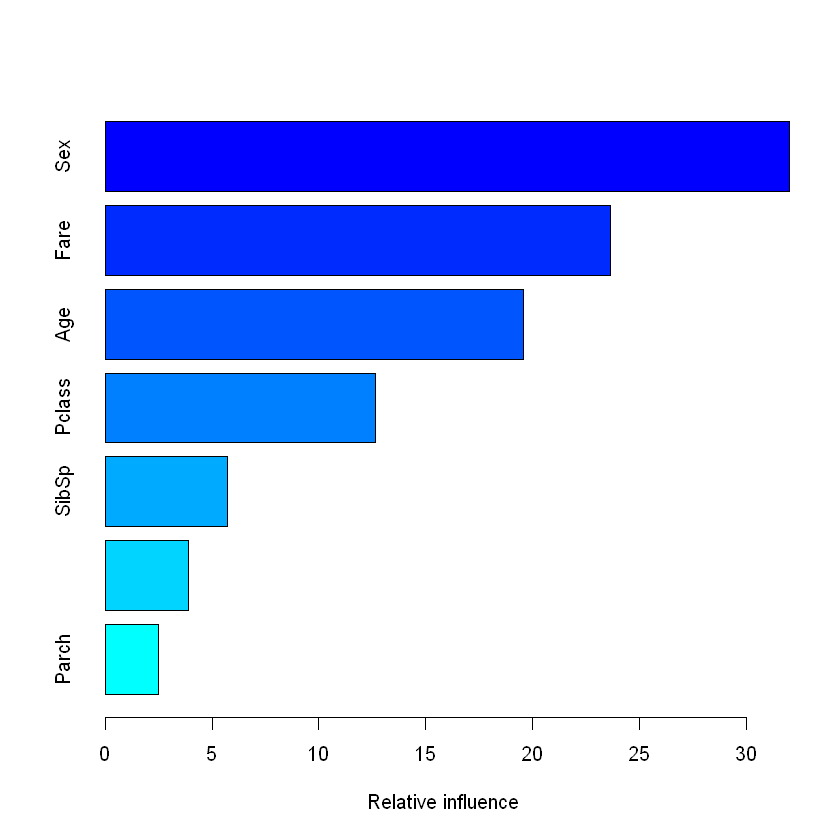

In [94]:
# Parms:
num_trees       <- 1000
shrinkage       <- 0.01
# Fit model:
set.seed(1)
boost.mod       <- gbm(Survived_bin~., data=real_train_gbm, n.trees=num_trees,
                       distribution="bernoulli", interaction.depth=4, shrinkage=shrinkage)
print(head(summary(boost.mod)))
# Predict:
set.seed(2)
boost.mod.pred  <- predict(boost.mod, newdata=real_test, n.trees=num_trees,
                          type="response")
summary(boost.mod.pred)
# Here I use 0.5 as cutoff to predict 0 or 1:
boost.pred.bin  <- ifelse(boost.mod.pred>0.5, 1, 0)
bst_pred_tab    <- table(boost.pred.bin, real_test$Survived)
print(bst_pred_tab)
print( sum(bst_pred_tab[1,1],bst_pred_tab[2,2])/sum(bst_pred_tab) )
# 86% predicted correctly; slight improvement over randomForest!

In [98]:
# Fourth, we try linear regression:
head(real_train_gbm)
lin_reg      <- lm(Survived_bin~., data=real_train_gbm)
lin_reg_pred <- predict(lin_reg, newdata=real_test)
summary(lin_reg_pred)
# Linear regression, unlike logistic, does not specify response 
# needs to be between 0 and 1.
# Use 0.5 cutoff again:
lin_reg_bin  <- ifelse(lin_reg_pred>0.5, 1, 0)
lin_pred_tab    <- table(lin_reg_bin, real_test$Survived)
print(lin_pred_tab)
print( sum(lin_pred_tab[1,1],lin_pred_tab[2,2])/sum(lin_pred_tab) )
# 81.6% predicted correctly; slightly worse than all above methods.

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived_bin
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
237,2,male,44.0,1,0,26.0,S,0
332,1,male,45.5,0,0,28.5,S,0
510,3,male,26.0,0,0,56.5,S,1
807,1,male,39.0,0,0,0.0,S,0
179,2,male,30.0,0,0,13.0,S,0
796,2,male,39.0,0,0,13.0,S,0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.483   0.113   0.259   0.354   0.608   1.113 

           
lin_reg_bin   0   1
          0 146  31
          1  18  72
[1] 0.816


In [103]:
# Fifth and last, we try logistic regression:
set.seed(1)
logis.mod       <- glm(Survived_bin~., data=real_train_gbm, family=binomial)
logis.mod.pred  <- predict(logis.mod, newdata=real_test, type="response")
summary(logis.mod.pred)
# Good.
# Use 0.5 cutoff again:
log_reg_bin  <- ifelse(logis.mod.pred>0.5, 1, 0)
log_pred_tab    <- table(log_reg_bin, real_test$Survived)
print(log_pred_tab)
print( sum(log_pred_tab[1,1],log_pred_tab[2,2])/sum(log_pred_tab) )
# 81.6% predicted correctly; same as above linear regression and 
# slightly worse than all above methods.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.100   0.229   0.360   0.634   0.973 

           
log_reg_bin   0   1
          0 145  30
          1  19  73
[1] 0.816


In [ ]:
# Bagging, boosting, and randomForest all have slightly better performance
# than linear and logistic regression.
# Boosting has the best performance here; slightly better than the
# other 2 ML approaches.